# ***PROJECT-B3TA***
## **notebook 01 | Data Loading, Cleaning and Initial EDA**  

---

#### Imports.

In [1]:
import numpy as np
import pandas as pd
## Pandas has a depedency on NumPy so loads automatically but best practice to load full NumPy package
print(f"Numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = 'notebook'

# sklearn
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity
print(f"skLearn version: {sk.__version__}")

# scipy
import scipy
from scipy.stats import norm

# statsmodels
import statsmodels.api as sm

# b3ta functions
import b3tafunc as b3


Numpy version: 1.24.3
pandas version: 2.0.3
skLearn version: 0.24.2


### 0. **Background**
- An extensive search for music data led me to explore a range of music services including YouTube, LastFm, SoundCloud but in the end, given the amount of data available and the access to the API for more tailored requests, Spotify became the primary focus for this project's data requirements.

- As a first step, a selection of existing Spotify datasets were explored.

    - **Spotify's Million Playlist dataset** was initially considered but then parked due to the scale, potentially a good repository for future expansion. [(link}](https://research.atspotify.com/2020/09/the-million-playlist-dataset-remastered/)

    - **Top Songs By Country May 2020** dataset too small and the 50 most popular songs by country data didn't accurately reflect the sound of a city / place (typically swayed by more global commercial factors). [(link)](https://www.kaggle.com/datasets/hkapoor/spotify-top-songs-by-country-may-2020 )

    - **Spotify Dataset 1921-2020, 600k+ Tracks** this is a solid dataset, good quantity of tracks but following a bit of digging didn't have the best selection of artists and also was crucially missing the genre field which could be a crucial feature when determining the sound of a location. [(link)](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv)

    - **Spotify_1Million_Tracks** this dataset was a good size allowing for plenty of initial exploration with a good range artists plus genre information and all the other standard spotify metrics from the more typical (key, tempo, duration) to the more esoteric (speechiness and danceability). There was however no location information whatsoever. [(link)](https://www.kaggle.com/datasets/amitanshjoshi/spotify-1million-tracks)

- Having exhausted publicly available datasets we looked to the Spotify API to provide us with location information. Unfortunately it turns out even the API doesn't offer much in the way of location data, whether it be relating to consumption or track uploads, anothe approach would be required..
    
    - **Spotify API** Given the lack of location information and not wanting to create a model based on the most listened to tracks in a given area (not exactly the best indicator of a locations authentic *sound*!) we needed a proxy. The solution? Create a set of 'sound profiles' for a number of locations from playlists containing a selection of tracks commonly associated with the sound of the area in question. We used the API to gather sound profiles for a mix of destinations ranging from London and New York to Berlin and Kingston, the aim being to select a mixture of locations with a spectrum of sounds that will give us a good range to create our model with. In the end we profiled sounds from the following cities;
    
        - London
        - Manchester
        - Berlin
        - Ibiza
        - Kingston
        - New York
        - LA

- What follows is a combination of cleaning and EDA as we prepare our dataset for future manipulation.

**Data Dictionary** (following initial clean and eda)

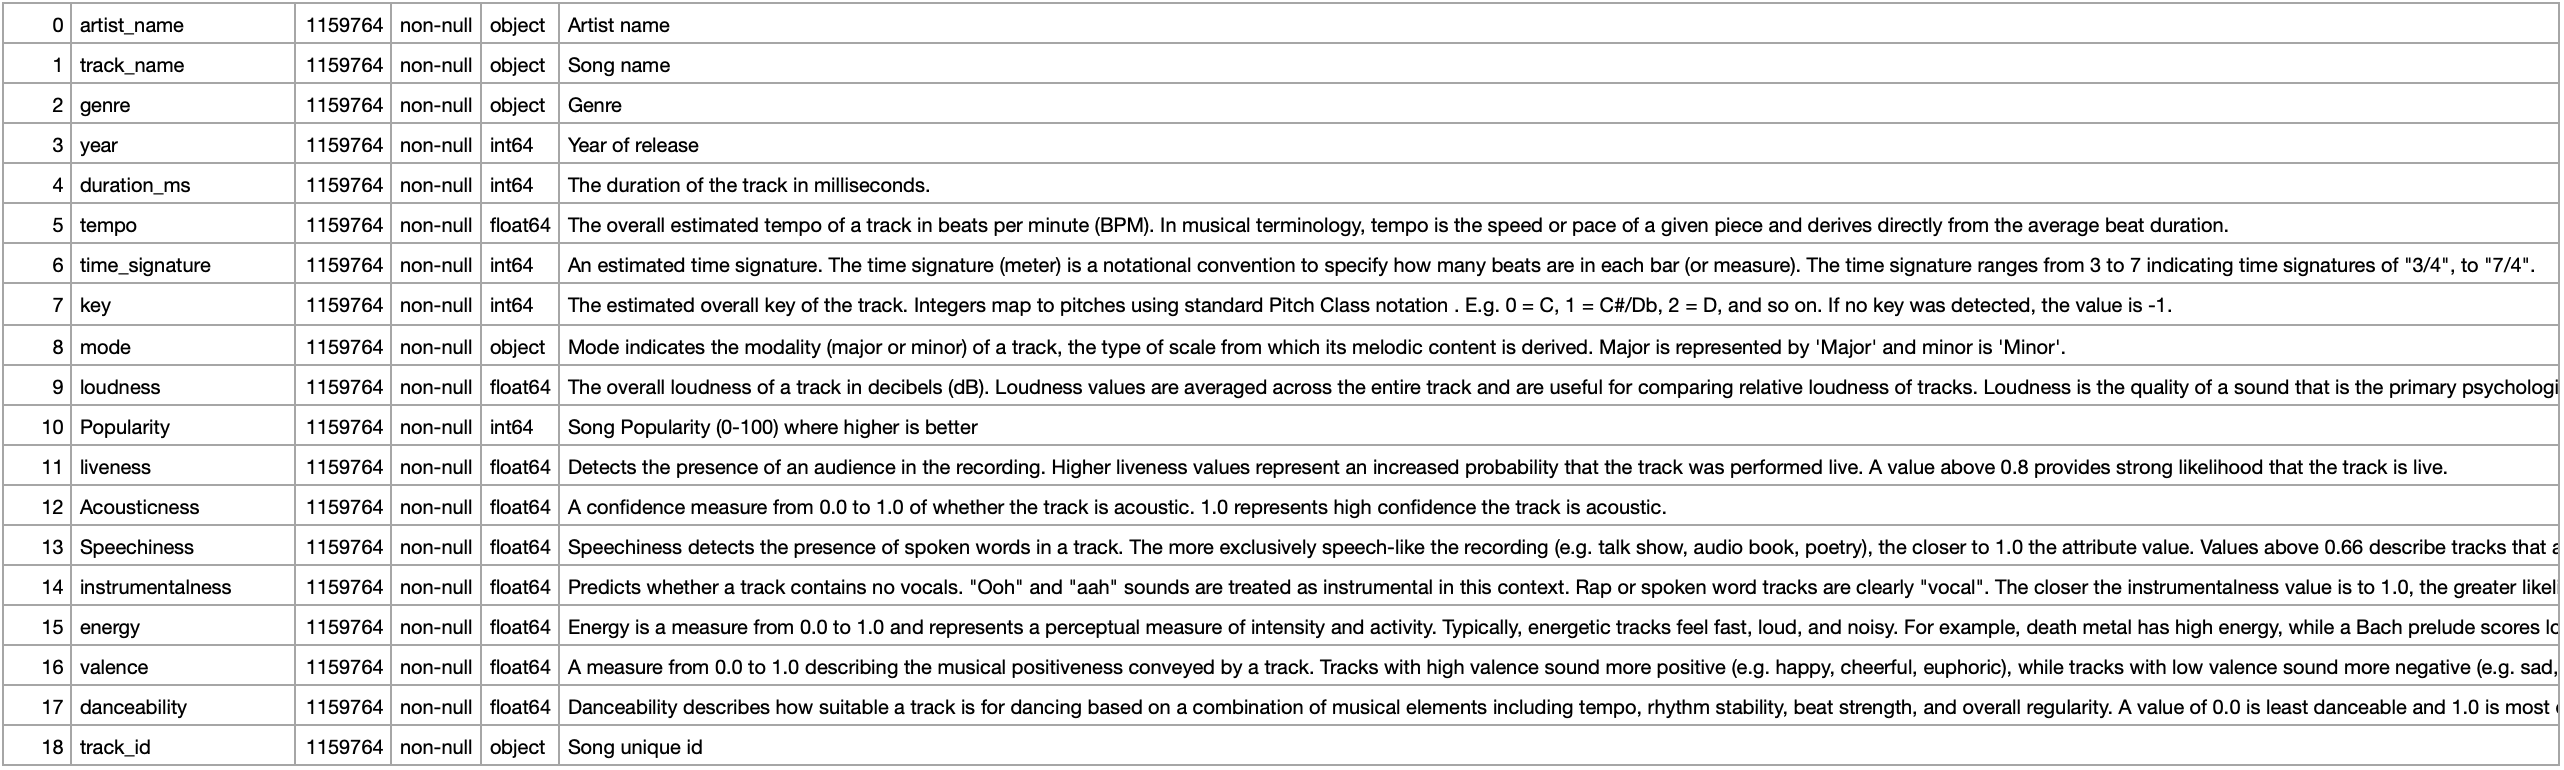

### 1. **Dataset Loading**

**Load main dataset.**

In [2]:
df = pd.read_csv("../data/kaggle_milliontracks_spotify_data.csv")
df.head(3)

Unnamed: 0    artist_name        track_name                track_id  \
0           0     Jason Mraz   I Won't Give Up  53QF56cjZA9RTuuMZDrSA6   
1           1     Jason Mraz  93 Million Miles  1s8tP3jP4GZcyHDsjvw218   
2           2  Joshua Hyslop  Do Not Let Me Go  7BRCa8MPiyuvr2VU3O9W0F   

   popularity  year     genre  danceability  energy  key  loudness  mode  \
0          68  2012  acoustic         0.483   0.303    4   -10.058     1   
1          50  2012  acoustic         0.572   0.454    3   -10.286     1   
2          57  2012  acoustic         0.409   0.234    3   -13.711     1   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0429         0.694          0.000000    0.1150    0.139  133.406   
1       0.0258         0.477          0.000014    0.0974    0.515  140.182   
2       0.0323         0.338          0.000050    0.0895    0.145  139.832   

   duration_ms  time_signature  
0       240166               3  
1       216387               4  
2       158960               4

### 2. **Orientation & Initial Cleaning**

#### Check rows and columns.
- 1,159,764 rows.
- 20 columns.

In [3]:
df.shape

(1159764, 20)

#### Duplicate rows check.
- No duplicates.

In [4]:
df.duplicated().value_counts()

False    1159764
Name: count, dtype: int64

#### Check NaNs.
- 16 NaNs in total. Given such a small fraction these will be dropped.

In [5]:
df.isna().sum()

Unnamed: 0           0
artist_name         15
track_name           1
track_id             0
popularity           0
year                 0
genre                0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
dtype: int64

In [6]:
nan_trackname = df[df["track_name"].isna()].index

#### Drop NaNs.

In [7]:
df.drop(index=nan_trackname, inplace=True)

In [8]:
nan_artistnames = df[df["artist_name"].isna()].index
nan_artistnames

Index([256971, 256972, 257024, 313028, 313050, 313063, 313117, 313153, 313174,
       313225, 369500, 369521, 369578, 369581, 369607],
      dtype='int64')

In [9]:
df.drop(index=nan_artistnames, inplace=True)

#### Check NaNs.

In [10]:
df.isna().sum()

Unnamed: 0          0
artist_name         0
track_name          0
track_id            0
popularity          0
year                0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

#### Overview of data with .info()
- A mixture of **int 64**, **float64** and **strings**.
- **0 NULL** values. (16 already dropped)
- All **columns** look fairly typical including all the usual spotify metrics.
- Dataset is looking fairly clean and suitable for purpose. It will form a good template for any further data that is imported during the project, the plan being to build functions to streamline the cleaning of future imports of data accessed vis the API.
- *'Unnamed: 0'* seems to be an index column which can be dropped.
- For a detailed breakdown of the **data dictionary** see seperate *'project-b3ta-data-dictionary.csv'*, this has been taken directly from [Spotify's developer site](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). This seemed to contain a good summary of metrics, however, its worth noting loudness likely represents specifically the perceived loudness of a track (LUFS) as opposed to the actual volume in dB. This has been checked via reference to familiar sources (Dua Lipa and Overmono). The Spotify description has likely been tailored for those without the audio engineering experience or they have infact subletly adapted loudness in some way. For the purposes of this project, this isn't something that likely will have a major impact.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1159748 entries, 0 to 1159763
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1159748 non-null  int64  
 1   artist_name       1159748 non-null  object 
 2   track_name        1159748 non-null  object 
 3   track_id          1159748 non-null  object 
 4   popularity        1159748 non-null  int64  
 5   year              1159748 non-null  int64  
 6   genre             1159748 non-null  object 
 7   danceability      1159748 non-null  float64
 8   energy            1159748 non-null  float64
 9   key               1159748 non-null  int64  
 10  loudness          1159748 non-null  float64
 11  mode              1159748 non-null  int64  
 12  speechiness       1159748 non-null  float64
 13  acousticness      1159748 non-null  float64
 14  instrumentalness  1159748 non-null  float64
 15  liveness          1159748 non-null  float64
 16  valen

#### Loudness checks.

In [12]:
# Check loudness LUFS assumption - Pop; Dua Lipa (high LUFS values, highly compressed)
df[df.sort_values("popularity", ascending=False)["artist_name"] == 'Dua Lipa'][["track_name", "loudness"]].head(5)

/var/folders/gq/z415nsvs5jn4krjp3qvb4s3m0000gn/T/ipykernel_48449/1257200176.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



track_name  loudness
197697                       Be the One    -3.771
224565            Blow Your Mind (Mwah)    -4.761
224853  Hotter Than Hell - Matoma Remix    -7.000
224891                       Room for 2    -5.752
225287                 Hotter Than Hell    -4.230

In [13]:
# Check loudness LUFS assumption - Dance; Overmono (medium LUFS values & some more dynamic tracks)
df[df.sort_values("popularity", ascending=False)["artist_name"] == 'Overmono'][["track_name", "loudness"]].head(5)

/var/folders/gq/z415nsvs5jn4krjp3qvb4s3m0000gn/T/ipykernel_48449/4197378610.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



track_name  loudness
328479    Quadraluv   -13.995
494445     So U Kno    -8.357
494533          Bby    -8.792
494719  Diamond Cut    -8.819
494844    If U Ever   -16.118

#### Further exploration and cleaning.

- **"Unnamed: 0" column dropped due to being an index duplicate**
    - "Unnamed: 0" column 1,159,764 uniques
    - Index 1,159,764 entries (must be unique)
    - Whilst same number of entries some seem to differ, following a bit of exploration looks like this was just a result of further editing post data extraction. No impact our requirements so column is dropped.
- **"track_id" column confirmed as unique**
    - Confirmed all entires unique.
    - Duplication with the index but kept in incase required as reference for any further API interaction.


In [14]:
pd.DataFrame(df["Unnamed: 0"].unique()).count()
# Count uniques

0    1159748
dtype: int64

In [15]:
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head(1)

artist_name       track_name                track_id  popularity  year  \
0  Jason Mraz  I Won't Give Up  53QF56cjZA9RTuuMZDrSA6          68  2012   

      genre  danceability  energy  key  loudness  mode  speechiness  \
0  acoustic         0.483   0.303    4   -10.058     1       0.0429   

   acousticness  instrumentalness  liveness  valence    tempo  duration_ms  \
0         0.694               0.0     0.115    0.139  133.406       240166   

   time_signature  
0               3

In [16]:
pd.DataFrame(df["track_id"].unique()).count()
# Sanity check 1,159,764 uniques, meaning all records are individual tracks

0    1159748
dtype: int64

#### Further exploration and cleaning - a quick look at features...

- **b3.df_snapshot_vc()**
    - Function to give a value count snapshot of each column in a dataframe. Points to note;
        - "**artist_name**" - 64,159 total number of artists. 'Traditional' looks like a generic name given to unknown artists / groups, 'Various Artists' and the like also likely to feature. One to bear in mind, no action required.
        - "**popularity**" - A large number of 0 rated tracks (158,391), could consider removing these and potentially a wider range of unpopular tracks to improve recommendations.
        - "**year**" - Earliest tracks in the database from 2000. We've no clarity on what this year relates to. Date uploaded to platform most likely but this still could mean tracks produced earlier are included. The inclusion of Johann Sebastian Bach & Elvis Presley in our column of artists confirms this. Given the lack of real meaning, and given that we don't really need our model to favour older more contemporary artists this column can be dropped.
        - "**genre**" - 82 different genres in total. Potentially an important metric for a location based algorithm given the propensity of certain genres in certain areas. Interesting to note, black-metal is the most popular genre! As this is a sample of data from Kaggle, the selection itself (despite its massive size) may skew our recommendations slightly. Just one to bare in mind for now.
        - "**energy**" - High numbers of tracks with high energy ratings, lower instances of lower energy ratings.
        - "**key**"" - Possibly will need converting into a categorical variable to avoid infering a numerical weighting, but we'll hold off for now until we understand more on the model(s) we'll be working with.
        - "**mode**" - Mode indicates a higher percentage of tracks in a major key, whilst this is technically a categorical vairable we will leave as is, we will need it in binary form for modelling.
        - "**acousticness**" - Maybe slightly surprisingly given the recent time-window, seemingly a large number of tracks with high accousticness ratings (i.e. lots of acoustic tracks).
        - "**instrumentalness**" - Potential for colinearity with 'speechiness'; an inverse relationship.
        - "**valence**" - High numbers of tracks with high valence scores (positive vibe), likely to correlate with high numbers of tracks with high energy ratings and also relatively high numbers of tracks in a major key.
        - "**tempo**" - A large number of tracks with a 0.000 score for tempo, presumably ambient. Unsurprisingly the rest of the top counts are around the 128bpm mark.
        - "**duration_ms**" - Top durations around the 2-4min mark (as expected).
        - "**time_signature**" - By far the most common time signature is 4/4 (no surprises there!) followed by 3/4. however, on closer inspection the numbers don't actually relate to Spotify's official discription so given the inconsistencies we will drop. Potentially to be explored further at a later date.
- **Column reorganisation**
    - Columns re-ordered following initial observation to place the columns likely to impact our recommendations closer to the left whilst keeping similar groups of columns together.


In [17]:
b3.df_snapshot_vc(df)

ARTIST_NAME:

artist_name
Traditional              4058
Grateful Dead            2320
Johann Sebastian Bach    2125
Giacomo Meyerbeer        1345
Elvis Presley            1242
                         ... 
Gaia Consort                1
Dzej Ramadanovski           1
Goca Trzan                  1
Robbie O'Connell            1
Sleep Therapist             1
Name: count, Length: 64158, dtype: int64


TRACK_NAME:

track_name
Intro                                      466
Home                                       313
Forever                                    229
Hold On                                    224
Stay                                       220
                                          ... 
Garden of Madness                            1
The Power Within (Altitude 2019 Anthem)      1
Homecoming (ABGT350WD) - Enamour Remix       1
Phone Down - BRKLYN Remix                    1
Hit the Road Jack (Pé Na Éstrada)            1
Name: count, Length: 882349, dtype: int64


TRACK_ID:

track

#### Re-ordering columns.

In [18]:
df = df.reindex(columns=['artist_name',
                    'track_name',
                    'genre',
                    'year',
                    'duration_ms',
                    'tempo',
                    'time_signature',
                    'key',
                    'mode',
                    'loudness',
                    'popularity',
                    'liveness',
                    'acousticness',
                    'speechiness',
                    'instrumentalness',
                    'energy',
                    'valence',
                    'danceability',
                    'track_id'
                   ])
df.head(1)
# Re-order columns

artist_name       track_name     genre  year  duration_ms    tempo  \
0  Jason Mraz  I Won't Give Up  acoustic  2012       240166  133.406   

   time_signature  key  mode  loudness  popularity  liveness  acousticness  \
0               3    4     1   -10.058          68     0.115         0.694   

   speechiness  instrumentalness  energy  valence  danceability  \
0       0.0429               0.0   0.303    0.139         0.483   

                 track_id  
0  53QF56cjZA9RTuuMZDrSA6

#### Drop year
- Drop year given inconsistencies and lack of real meaning (see above)

In [19]:
df.drop(columns='year', inplace=True)

#### Drop time_signature
- Given the discrepencies in numbering vs. Spotify's official discription (see above)

In [20]:
df.drop(columns='time_signature', inplace=True)

### 3. **Initial Univariate Review of Main Dataset**

#### Split numerical and categorical columns with **b3.df_numcat()**.
- Function that takes a single DataFrame as an argument and returns two DataFrames; A copy of the categorical columns (df_cat) and a copy of the numerical columns (df_num).
     - As above, whilst "**time_signature**" and "**key**" should possible be seen as categorical (so potential for string conversion) I'm keeping as they are for now until I have more clarity on the model approach.


In [21]:
df_cat, df_num = b3.df_numcat(df)
df_cat.head(1)

artist_name       track_name     genre                track_id
0  Jason Mraz  I Won't Give Up  acoustic  53QF56cjZA9RTuuMZDrSA6

In [22]:
df_num.head(1)

duration_ms    tempo  key  mode  loudness  popularity  liveness  \
0       240166  133.406    4     1   -10.058          68     0.115   

   acousticness  speechiness  instrumentalness  energy  valence  danceability  
0         0.694       0.0429               0.0   0.303    0.139         0.483

#### Univariate Analysis - **Categorical column exploration**.
- **Genres**
    - 82 Genres. Biggest class accounts for less that 2%. Genres could well play an important role in this project given the close association with place (local scenes).
    - 82 categories however, is too much to process with hot ones, we will need to formulate a plan how to reduce down (collapse sub genres?)

#### Genres.

In [23]:
genre_counts = df_cat["genre"].value_counts()
genre_counts_nmlz = df_cat["genre"].value_counts(normalize=True)
genre_counts_nmlz = round(genre_counts_nmlz * 100, 2)
genre_counts_nmlz

genre
black-metal       1.88
gospel            1.86
ambient           1.84
acoustic          1.82
alt-rock          1.80
                  ... 
chicago-house     0.45
dubstep           0.41
detroit-techno    0.34
rock              0.29
songwriter        0.05
Name: proportion, Length: 82, dtype: float64

In [24]:
import plotly.graph_objects as go

# Calculate total count
total_count = genre_counts.sum()

# Calculate percentage of total count for each genre
percentages = (genre_counts / total_count) * 100

# genres by counts 
fig = go.Figure()

genres = genre_counts.index
counts = genre_counts.values

# Generate hover text with count and percentage
hover_text = [f'Count: {count}<br>Percentage of Total: {percent:.2f}%' 
              for count, percent in zip(counts, percentages)]

genre_cnts = go.Bar(
    x=genres,
    y=counts,
    name='Genre',
    marker_color="#1DFD54",
    opacity=0.8,
    hovertext=hover_text  # Set hover text
)

fig.add_trace(genre_cnts)

chart_layout = go.Layout(
    width=2000,
    height=600,
    title='Genres',
    xaxis_title='Genre',
    yaxis_title='Count'
)

fig.update_layout(chart_layout)

fig.show()


#### Univariate Analysis - **Numerical column exploration**.
- **df_numstats()**
    - Takes a single DataFrame as an argument (Numeric variables only).
    - Prints key stats metrics for each column; Mean, Median, Range, IQR, Standard Deviation, Max and Min
- **df_histoboxme()**
    - Creates a histogram and box plot for each feature of a df containing numeric values
- **Key observations**;
    - "**duration_ms**" - potentially some wild outliers to remove (max is 40x standard deviations away from the mean
    - "**tempo**" - looks like normally distributed around a mean of 121bpm
    - "**loudness**" - negative skew, likely a result of the loudness war (https://en.wikipedia.org/wiki/Loudness_war)
    - "**popularity**" - a large number of 0 rated tracks which we can see clearly in our histogram, an obvious anomoly, 0 being by far the most numerous rating count across the dataset. Whilst the initial hypothesis was that it could have been due to lack of listens but having reviewed our sound profiles it turns out a lot of these tracks also have a zero popularity, pretty odd given that list includes big names ranging from Bob Marley and Frankie Knuckles to Disclosure and Guns N Roses. Given this, whilst it feels like a bit of shame to remove the rating cannot be trusted so it must be dropped (dropped following multivariate analysis). If time allows we will experiment modelling with it both included and excluded to see how it impacts our results.
    - "**acousticness**" - has two peaks although primarily distrubted towards the bottom end, similar pattern in speechniess and instrumentalness, possibly related? One to inspect further (correlations)
    - "**valence**" - some big count outliers at the extreme ends of the distribution
    - "**danceability**" - looks fairly normally distributed, link to tempo?
    
        

In [25]:
df_num.head(1)

duration_ms    tempo  key  mode  loudness  popularity  liveness  \
0       240166  133.406    4     1   -10.058          68     0.115   

   acousticness  speechiness  instrumentalness  energy  valence  danceability  
0         0.694       0.0429               0.0   0.303    0.139         0.483

In [26]:
df_num

duration_ms    tempo  key  mode  loudness  popularity  liveness  \
0             240166  133.406    4     1   -10.058          68    0.1150   
1             216387  140.182    3     1   -10.286          50    0.0974   
2             158960  139.832    3     1   -13.711          57    0.0895   
3             304293  204.961   10     1    -9.845          58    0.0797   
4             244320  171.864    6     0    -5.419          54    0.1100   
...              ...      ...  ...   ...       ...         ...       ...   
1159759       344013  107.951   10     0    -6.453           4    0.1590   
1159760       285067  119.897    7     0    -7.588           3    0.1300   
1159761       214253  100.076    5     1    -8.512           2    0.0936   
1159762       239133  133.885    0     1   -13.343           0    0.1250   
1159763       212227   89.987    1     0    -7.292           3    0.0581   

         acousticness  speechiness  instrumentalness  energy  valence  \
0              0.6940       0.0429          0.000000   0.303   0.1390   
1              0.4770       0.0258          0.000014   0.454   0.5150   
2              0.3380       0.0323          0.000050   0.234   0.1450   
3              0.8070       0.0363          0.000000   0.251   0.5080   
4              0.0726       0.0302          0.019300   0.791   0.2170   
...               ...          ...               ...     ...      ...   
1159759        0.3250       0.0736          0.000141   0.742   0.5220   
1159760        0.7880       0.0326          0.000129   0.675   0.2640   
1159761        0.4770       0.0274          0.003130   0.440   0.0351   
1159762        0.4310       0.0276          0.000063   0.405   0.2020   
1159763        0.2200       0.1250          0.000008   0.861   0.8570   

         danceability  
0               0.483  
1               0.572  
2               0.409  
3               0.392  
4               0.430  
...               ...  
1159759         0.373  
1159760         0.516  
1159761         0.491  
1159762         0.480  
1159763         0.782  

[1159748 rows x 13 columns]

In [27]:
b3.df_numstats(df_num)

DURATION_MS
MEAN: 249558.72
MEDIAN: 225740.5
RANGE: 5998422
IQR: 105816.0
STANDARDDEVIATION: 149424.27
MAX: 6000495
MIN: 2073



TEMPO
MEAN: 121.38
MEDIAN: 121.93
RANGE: 249.99
IQR: 41.1
STANDARDDEVIATION: 29.78
MAX: 249.99
MIN: 0.0



KEY
MEAN: 5.29
MEDIAN: 5.0
RANGE: 11
IQR: 6.0
STANDARDDEVIATION: 3.56
MAX: 11
MIN: 0



MODE
MEAN: 0.63
MEDIAN: 1.0
RANGE: 1
IQR: 1.0
STANDARDDEVIATION: 0.48
MAX: 1
MIN: 0



LOUDNESS
MEAN: -8.98
MEDIAN: -7.45
RANGE: 64.27
IQR: 5.55
STANDARDDEVIATION: 5.68
MAX: 6.17
MIN: -58.1



POPULARITY
MEAN: 18.38
MEDIAN: 15.0
RANGE: 100
IQR: 24.0
STANDARDDEVIATION: 15.89
MAX: 100
MIN: 0



LIVENESS
MEAN: 0.22
MEDIAN: 0.13
RANGE: 1.0


IQR: 0.19
STANDARDDEVIATION: 0.2
MAX: 1.0
MIN: 0.0



ACOUSTICNESS
MEAN: 0.32
MEDIAN: 0.15
RANGE: 1.0
IQR: 0.63
STANDARDDEVIATION: 0.35
MAX: 1.0
MIN: 0.0



SPEECHINESS
MEAN: 0.09
MEDIAN: 0.05
RANGE: 0.97
IQR: 0.05
STANDARDDEVIATION: 0.13
MAX: 0.97
MIN: 0.0



INSTRUMENTALNESS
MEAN: 0.25
MEDIAN: 0.0
RANGE: 1.0
IQR: 0.61
STANDARDDEVIATION: 0.37
MAX: 1.0
MIN: 0.0



ENERGY
MEAN: 0.64
MEDIAN: 0.69
RANGE: 1.0
IQR: 0.42
STANDARDDEVIATION: 0.27
MAX: 1.0
MIN: 0.0



VALENCE
MEAN: 0.46
MEDIAN: 0.44
RANGE: 1.0
IQR: 0.45
STANDARDDEVIATION: 0.27
MAX: 1.0
MIN: 0.0



DANCEABILITY
MEAN: 0.54
MEDIAN: 0.55
RANGE: 0.99
IQR: 0.26
STANDARDDEVIATION: 0.18
MAX: 0.99
MIN: 0.0





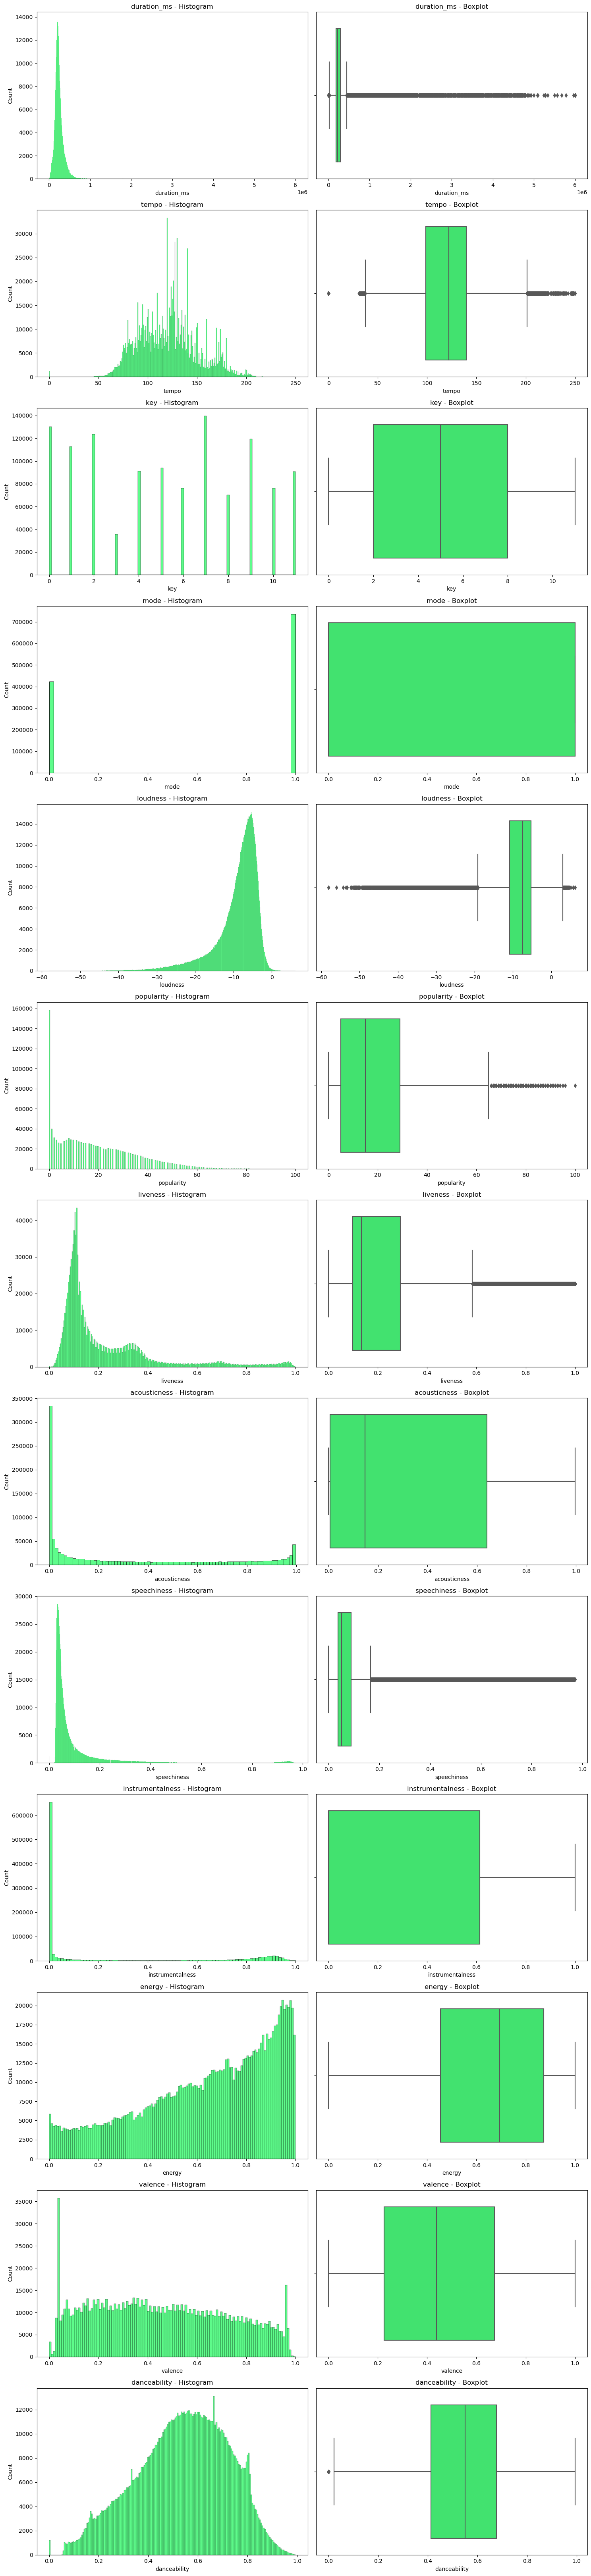

In [28]:
b3.df_histoboxme(df_num)

#### Popularity - remove.
- Here we see an obvious anomoly, 0 popularity rating being by far the most numerous rating count across the dataset. The reason? The initial hypothesis was that it would likely be due to lack of listens vs. there being a lot of rubbish on the platform. However, having reviewed our sound profiles it turns out a lot of these tracks also have a zero popularity, pretty odd given that list includes big names ranging from Bob Marley and Frankie Knuckles to Disclosure and Guns N Roses.
- Whilst it feels like a bit of shame to drop popularity in it's entirety, given the calibre of artists and tracks receiving a 0 rating it can't be trusted so it will be removed.
- If time allows we will experiment modelling with it both included and excluded to see how it impacts our results.

In [29]:
#df50['popularity'].value_counts()

In [30]:
#df50['popularity'].value_counts(normalize=True)

In [31]:
'''
# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1 - Histogram
axes[0].hist(df50['popularity'], bins=98, color='#28fc64', alpha=0.8)  # edgecolor='black' - adjust edge color
axes[0].set_xlabel('Popularity Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Track Popularity Rating Histogram')
axes[0].ticklabel_format(style='plain', axis='x')

# Plot 2 - Boxplot
sns.boxplot(data=df50, x=df50['popularity'], color='#28fc64');
axes[1].set_xlabel('Popularity Rating')
axes[1].set_title('Track Popularity Rating Boxplot')

plt.tight_layout()
plt.show()

b3.df_numstats(df50[['popularity']])
'''

"\n# Set up the figure and axes\nfig, axes = plt.subplots(1, 2, figsize=(15, 5))\n\n# Plot 1 - Histogram\naxes[0].hist(df50['popularity'], bins=98, color='#28fc64', alpha=0.8)  # edgecolor='black' - adjust edge color\naxes[0].set_xlabel('Popularity Rating')\naxes[0].set_ylabel('Frequency')\naxes[0].set_title('Track Popularity Rating Histogram')\naxes[0].ticklabel_format(style='plain', axis='x')\n\n# Plot 2 - Boxplot\nsns.boxplot(data=df50, x=df50['popularity'], color='#28fc64');\naxes[1].set_xlabel('Popularity Rating')\naxes[1].set_title('Track Popularity Rating Boxplot')\n\nplt.tight_layout()\nplt.show()\n\nb3.df_numstats(df50[['popularity']])\n"

In [32]:
'''
# Check if any tracks featured in our sound profiles have  0 popularity
combined_snd_samp[combined_snd_samp['popularity'] == 0]
'''

"\n# Check if any tracks featured in our sound profiles have  0 popularity\ncombined_snd_samp[combined_snd_samp['popularity'] == 0]\n"

In [33]:
'''
print(f"df50: {df50.shape}")
print(f"df: {df.shape}")
'''

'\nprint(f"df50: {df50.shape}")\nprint(f"df: {df.shape}")\n'

In [34]:
'''
# Drop column
df50.drop(columns='popularity', inplace=True)
df.drop(columns='popularity', inplace=True)

print(f"df50: {df50.shape}")
print(f"df: {df.shape}")
'''

'\n# Drop column\ndf50.drop(columns=\'popularity\', inplace=True)\ndf.drop(columns=\'popularity\', inplace=True)\n\nprint(f"df50: {df50.shape}")\nprint(f"df: {df.shape}")\n'

### 4. **Initial Bivariate Review of Main Dataset**

#### Initial Bivariate Analysis - **Numerical column correlation heatmap**.
- In the absence of an obvious y target, we consider relationships across the numerical variables. Some initial observations;        
    - loudness and energy (strong positive)
    - loudness and acousticness (strong negative) 
    - acousticness and energy (strong negative)
    - valence and danceability (positive)
    - loudness and instrumentalness (negative)
    - loudness and tempo, valence, danceability (weak positive)
    - liveness and speechless (weak positive)
    - tempo and acousticness (weak negative)
    - key and mode (weak negative) - unusual

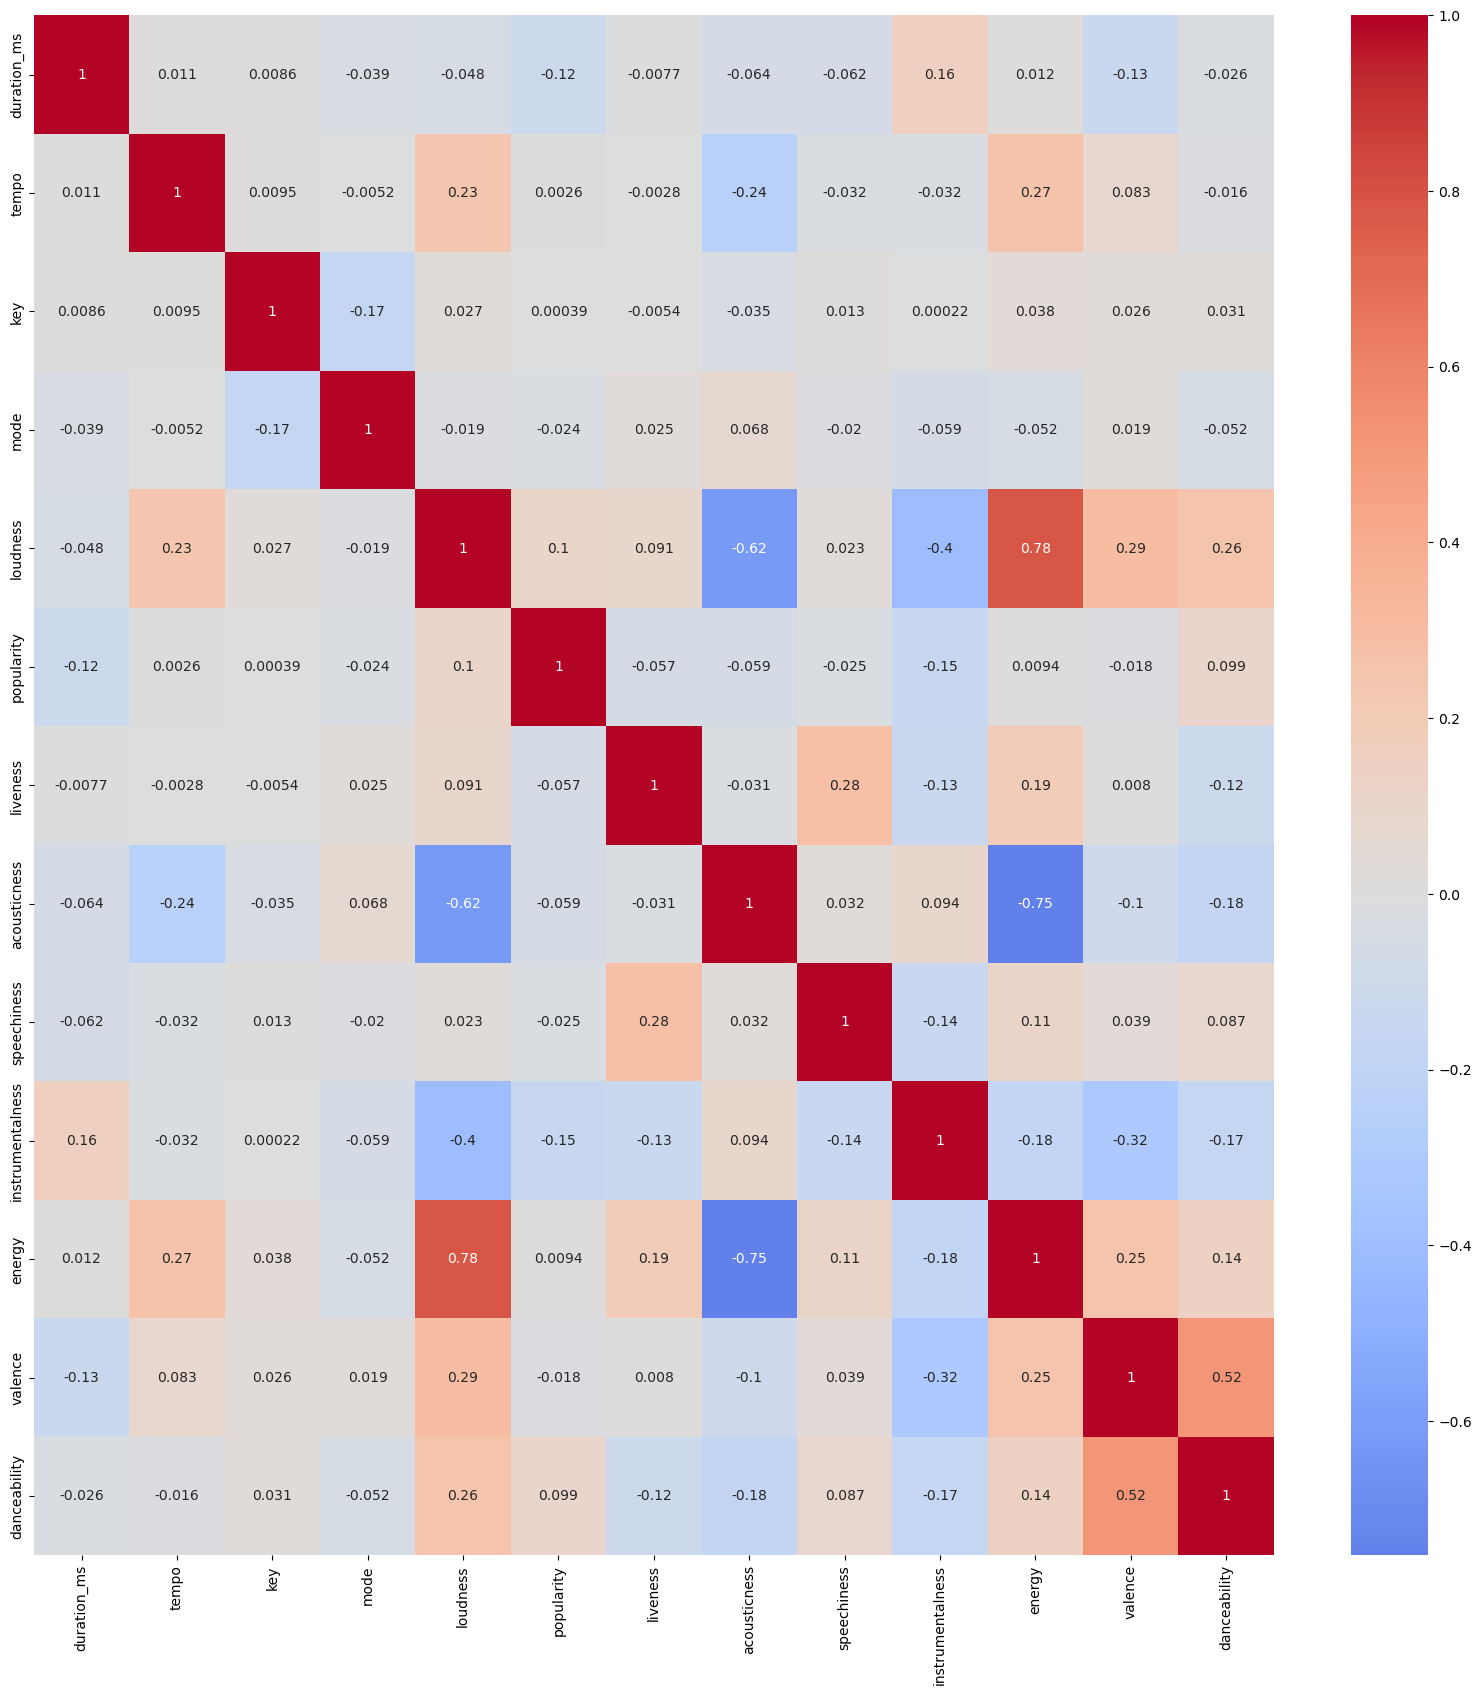

In [35]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_num.corr(), cmap='coolwarm', annot=True, center = 0)
plt.show()

#### Initial Bivariate Analysis - **Track Relationships and the Cosine Similarity**.
- **LondonSound comparison to a random sample**
    - Here we created a quick ***london_sound*** 'playlist' comprised of tracks from a range London artists.
    - The aim was to use the cosine similarity to compare the relationship amongst London artists, with the relationship of a random sample of tracks ***random_sample*** (numeric cols only). The hypothesis was the relationships between London artist columns would be stronger when compared..
    - When comparing absolute sum of cosine similarities between column vectors for each df - london_sound and random_sound, potential promise shown... (also held true for just the straight sum - ie not absolute)
    - As plot shows high score for london_sound suggests (slightly) stronger relationship but more work in this area in needed to draw any solid conclusions.

#### Define London sound profile.

In [36]:
#1 Burial
burial = df[df["artist_name"] == 'Burial']
burial = burial.sort_values("popularity", ascending=False).head()
#2 Dizzee Rascal
dizzee = df[df["artist_name"] == 'Dizzee Rascal'][11:16]
#3 Sex Pistols
sex_pistols = df[df["artist_name"] == 'Sex Pistols']
sex_pistols = sex_pistols.sort_values("popularity", ascending=False).head()
#4 The Clash
clash = df[df["artist_name"] == 'The Clash']
clash = clash.head()
#5 The Rolling Stones
stones = df[df["artist_name"] == 'The Rolling Stones']
stones = stones.sort_values("popularity", ascending=False).head()
#6 Amy Winehouse
amy = df[df["artist_name"] == 'Amy Winehouse']
amy = amy.sort_values("popularity", ascending=False).head()
#7 Jamie xx
jamiexx = df[df["artist_name"] == 'Jamie xx'][1:6]
#8 The Libertines
libs = df[df["artist_name"] == 'The Libertines']
libs = libs.sort_values("popularity", ascending=False).head()
#9 Elton John
elton = df[df["artist_name"] == 'Elton John']
elton = elton.sort_values("popularity", ascending=False).head()
#10 David Bowie
bowie = df[df["artist_name"] == 'David Bowie']
bowie = bowie.sort_values("popularity", ascending=False).head()
#11 Blur
blur = df[df["artist_name"] == 'Blur']
blur = blur.sort_values("popularity", ascending=False).head()
#12 
overmono = df[df["artist_name"] == 'Overmono']
overmono = overmono.sort_values("popularity", ascending=False).head()

In [37]:
london_sound = pd.concat([blur, bowie, elton, libs, jamiexx, amy, stones, clash, sex_pistols, dizzee, burial, overmono], axis=0)
london_sound.head(3)


artist_name    track_name     genre  duration_ms    tempo  key  mode  \
623677        Blur  Girls & Boys  alt-rock       259387  120.048    7     0   
623895        Blur      Parklife  alt-rock       187040  138.391    4     1   
752183        Blur     Good Song  alt-rock       187680  168.544    5     1   

        loudness  popularity  liveness  acousticness  speechiness  \
623677    -8.354          67    0.0601       0.00986       0.0315   
623895    -6.905          55    0.3280       0.15400       0.0606   
752183    -9.113          53    0.1880       0.21300       0.0286   

        instrumentalness  energy  valence  danceability  \
623677             0.000   0.875    0.899         0.693   
623895             0.000   0.877    0.749         0.632   
752183             0.538   0.493    0.719         0.651   

                      track_id  
623677  5CeL9C3bsoe4yzYS1Qz8cw  
623895  3mqRLlD9j92BBv1ueFhJ1l  
752183  75WFyYrXPMAWyN6jOBB7IC

#### Create random sample for comparison.

In [38]:
random_sample = df.sample(60, random_state=4)
random_sample.head(3)

artist_name                         track_name      genre  \
1148544     Rockpile  Crawling From The Wreckage - Live  power-pop   
171077   Kyle Kinane                Corporately Stifled     comedy   
919039   Los Van Van                    Que Palo Es Ese      salsa   

         duration_ms    tempo  key  mode  loudness  popularity  liveness  \
1148544       187320  173.414    7     1    -7.352           6     0.790   
171077        114463  126.295    7     0    -5.107          19     0.844   
919039        302373  110.419    2     0    -9.449           7     0.068   

         acousticness  speechiness  instrumentalness  energy  valence  \
1148544         0.137       0.0804           0.00704   0.966    0.683   
171077          0.712       0.9170           0.00000   0.773    0.674   
919039          0.277       0.1480           0.00000   0.604    0.924   

         danceability                track_id  
1148544         0.365  5HswXtGk1ZkNlN7Bf6YWSc  
171077          0.639  5MEFDZ1egUFMSVujSRFkyz  
919039          0.646  7HmFjtRZd5XZKWxhY4Ozi8

#### Divide numerical and categorical.

In [39]:
ldn_df_cat, ldn_df_num = b3.df_numcat(london_sound)
rand_df_cat, rand_df_num = b3.df_numcat(random_sample)

#### Scale.

In [40]:
from sklearn.preprocessing import StandardScaler

# Make scaler
standard_scaler = StandardScaler()

# 3. fit the scaler
standard_scaler.fit(ldn_df_num)

# 4. transform the data (//nb - output is an np.array)
ldn_df_num_scl = standard_scaler.transform(ldn_df_num)


In [41]:
type(ldn_df_num_scl)

numpy.ndarray

In [42]:
from sklearn.preprocessing import StandardScaler

# Make scaler
standard_scaler = StandardScaler()

# 3. fit the scaler
standard_scaler.fit(rand_df_num)

# 4. transform the data.
rand_df_num_scl = standard_scaler.transform(rand_df_num)

#### Calc cosine distance and plot - London.
- Quantifies the similarity between two vectors in a multidimensional space.
    - 1 indicates identical vectors. More red = more similar.
    - 0 indicates orthogonal (unrelated) vectors. More grey = no relationship.
    - 1 indicates vectors are diametrically opposed. More blue = more opposed.
- Plot shows just the first column of the heatmap representing the relationships of each track against the first.

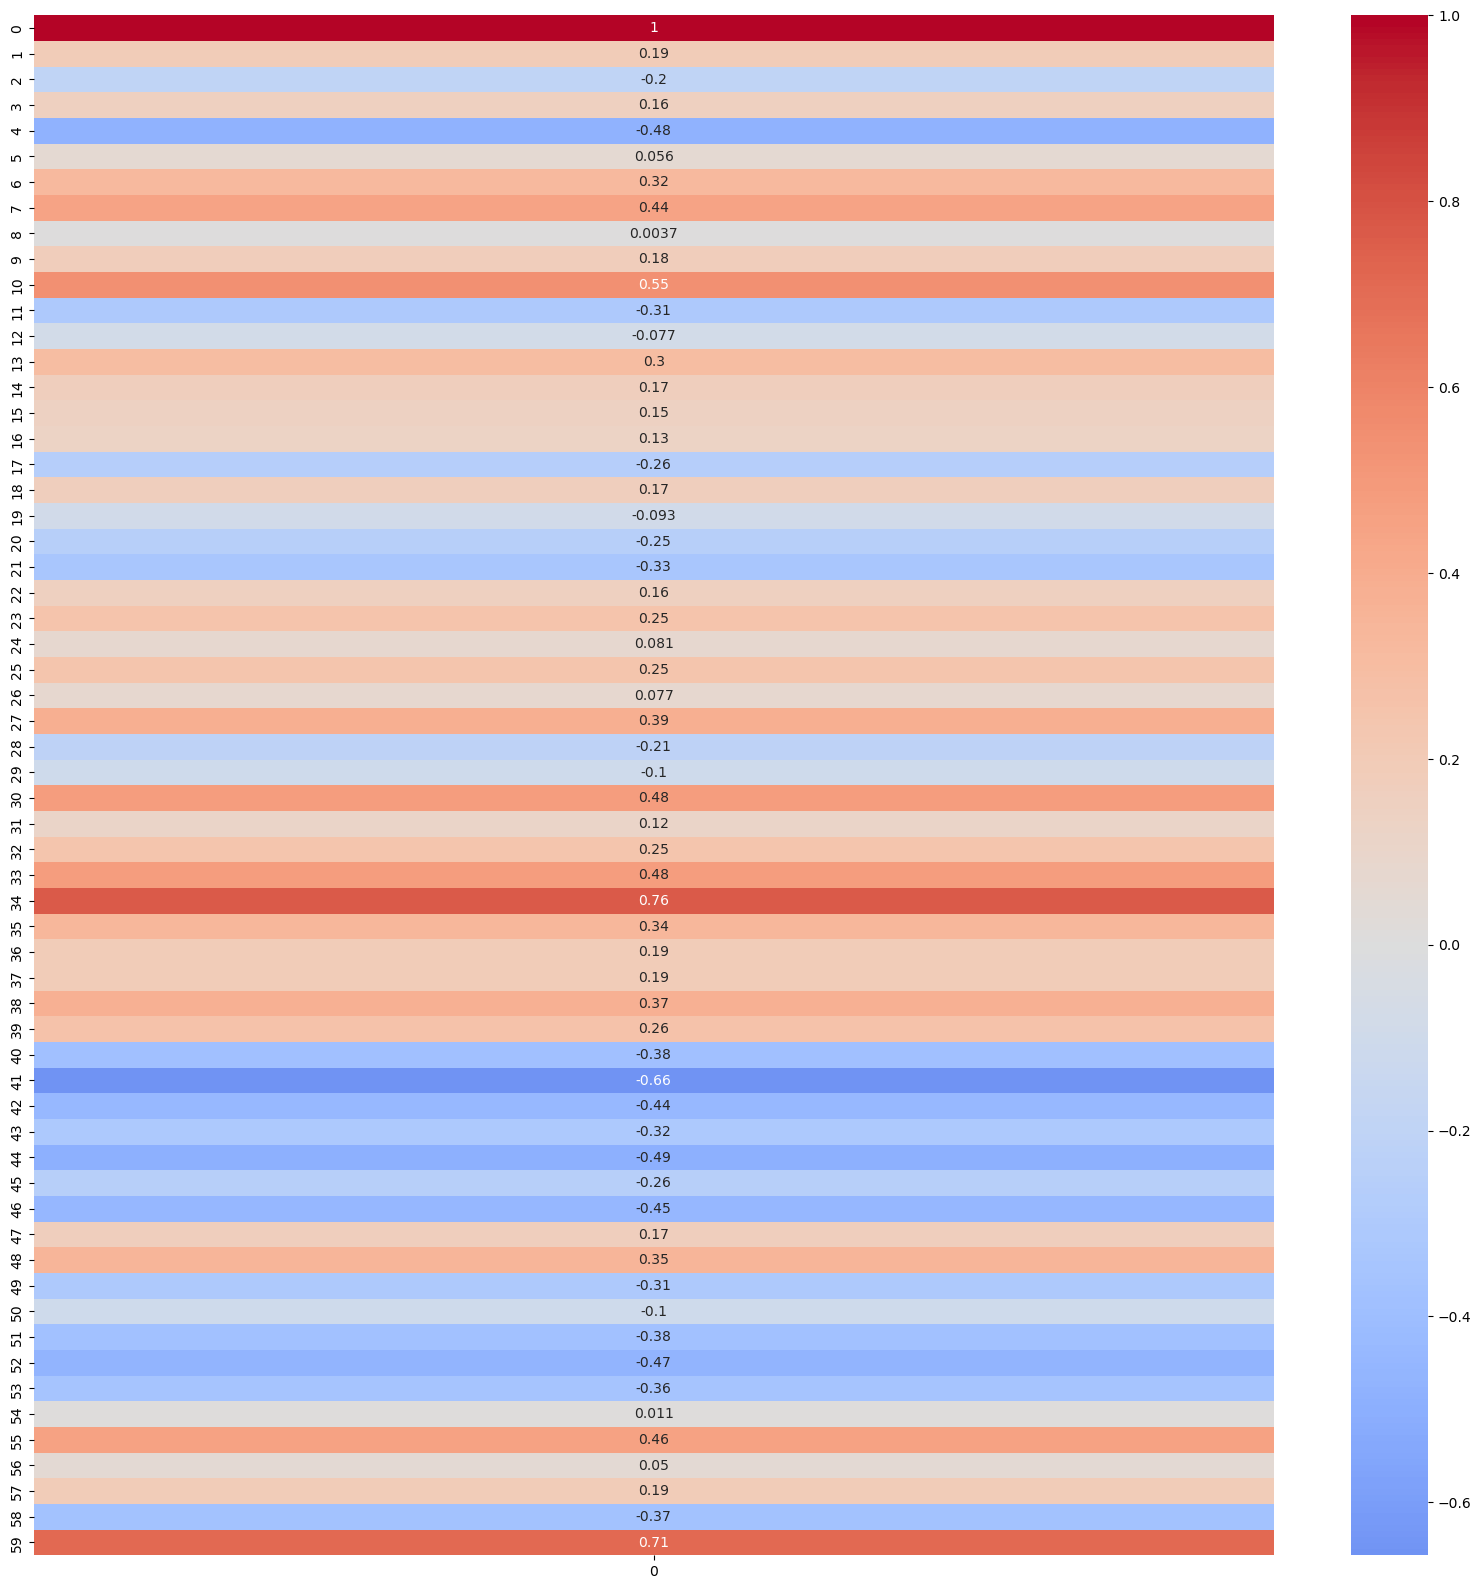

In [43]:
# Import
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity
ldn_df_num_scl_cosim = cosine_similarity(ldn_df_num_scl)

# Convert cosine similarity to DataFrame
ldn_df_num_scl_cosim_df = pd.DataFrame(ldn_df_num_scl_cosim)

# Calc cosine distance
ldn_df_num_scl_codis_df = 1 - ldn_df_num_scl_cosim_df

plt.figure(figsize=(20, 20))
sns.heatmap(ldn_df_num_scl_cosim_df.iloc[:, [0]], cmap='coolwarm', annot=True, center = 0)
plt.show()


#### Calc cosine distance and plot - Random.
- As above, quantifies the similarity between two vectors in a multidimensional space.
    - 1 indicates identical vectors. More red = more similar.
    - 0 indicates orthogonal (unrelated) vectors. More grey = no relationship.
    - 1 indicates vectors are diametrically opposed. More blue = more opposed.
- Plot shows just the first column of the heatmap representing the relationships of each track against the first.

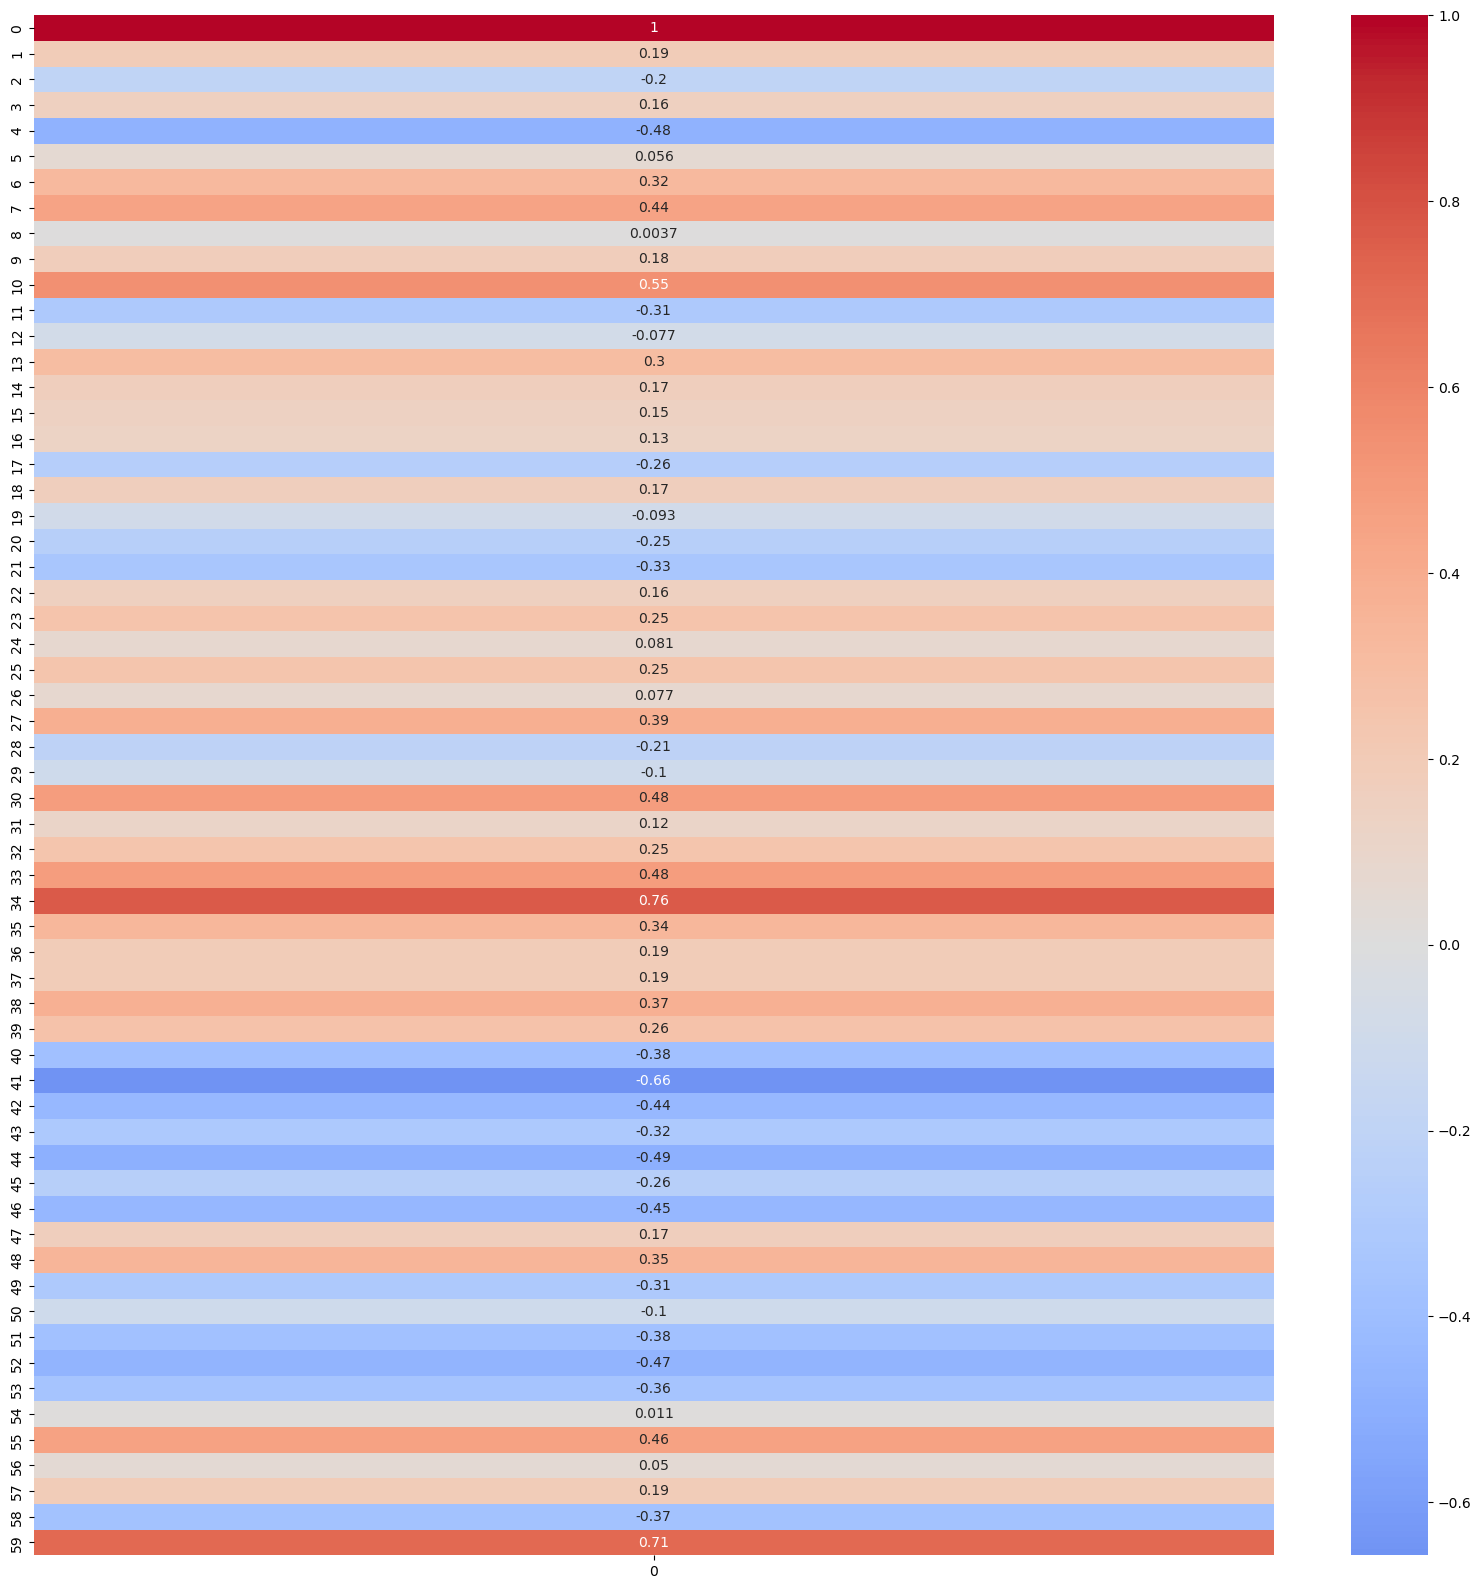

In [44]:
# Calculate cosine similarity
rand_df_num_scl_cosim = cosine_similarity(rand_df_num_scl)

# Convert cosine similarity to DataFrame
rand_df_num_scl_cosim_df = pd.DataFrame(rand_df_num_scl_cosim)

# Calc cosine distance
rand_df_num_scl_codis_df = 1 - rand_df_num_scl_cosim_df

plt.figure(figsize=(20, 20))
sns.heatmap(ldn_df_num_scl_cosim_df.iloc[:, [0]], cmap='coolwarm', annot=True, center = 0)
plt.show()


#### Plot cosine similarities for both London sound and Random sample.
- Here we see london tracks do seem more similar to our random sample.

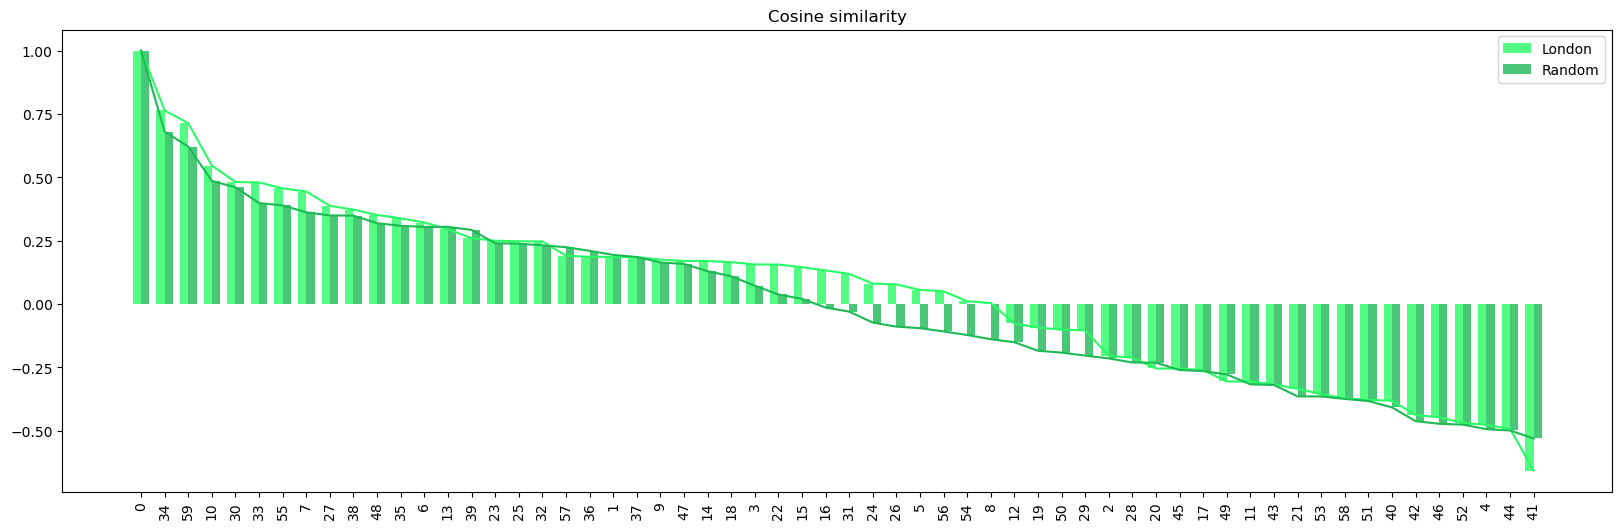

In [45]:
bar_width = 0.35

x_indices = np.arange(len(ldn_df_num_scl_cosim_df.iloc[:, [0]]))

# Sort the values in descending order
ldn_sorted_values = ldn_df_num_scl_cosim_df.iloc[:, [0]][0].sort_values(ascending=False)
rand_sorted_values = rand_df_num_scl_cosim_df.iloc[:, [0]][0].sort_values(ascending=False)

plt.figure(figsize=(20, 6))
plt.bar(x_indices - bar_width/2, ldn_sorted_values, color='#28fc64', width=bar_width, label='London', alpha=0.8) 
plt.bar(x_indices + bar_width/2, rand_sorted_values, color='#1DB954', width=bar_width, label='Random', alpha=0.8) 
plt.plot(x_indices, ldn_sorted_values, color='#28fc64') 
plt.plot(x_indices, rand_sorted_values, color='#1DB954') 

# Set x-axis labels
plt.xticks(x_indices, ldn_sorted_values.index, rotation=90)  # Use the index of sorted values
plt.legend()
plt.title('Cosine similarity')
plt.show()


#### Calculate and compare average cosine distances.
- London sound less opposed.

In [46]:
codis_ldn_avg = ldn_df_num_scl_codis_df.iloc[:, [0]].sum() / len(ldn_df_num_scl_codis_df.iloc[:, [0]])
codis_ldn_avg
# Average cosine distance ldn

0    0.948749
dtype: float64

In [47]:
codis_rand_avg = rand_df_num_scl_codis_df.iloc[:, [0]].sum() / len(rand_df_num_scl_codis_df.iloc[:, [0]])
codis_rand_avg
# Average cosine distance rand

0    0.991816
dtype: float64

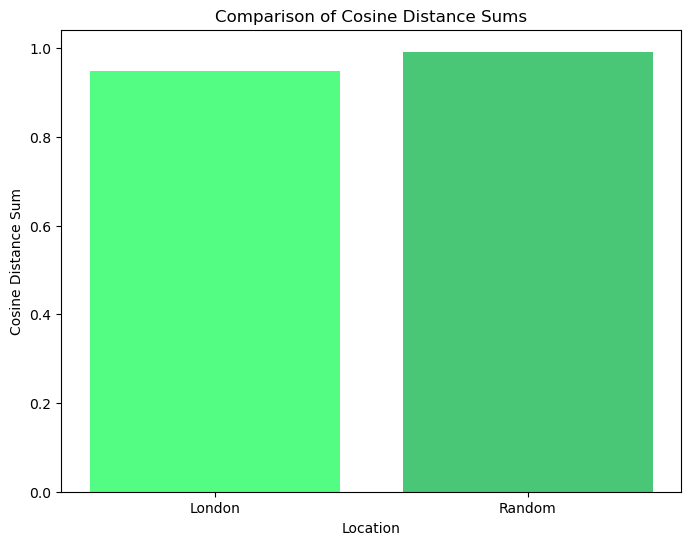

In [48]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.bar(['London', 'Random'], [codis_ldn_avg[0], codis_rand_avg[0]], color=['#28fc64', '#1DB954'], alpha=0.8)
plt.xlabel('Location')
plt.ylabel('Cosine Distance Sum')
plt.title('Comparison of Cosine Distance Sums')
plt.show()


#### Drop popularity
- Drop given the lack of trustworthiness of the scores (see above)

In [49]:
df.drop(columns='popularity', inplace=True)

### ***SUMMARY OF WORK TO DATE...***
- Initial EDA shows promise, we have a relatively clean dataset of good size and quality.
- Given the brief (playlist recommendation) the sooner we can lock down model approach the better as this may influence any further cleaning, pre-processing and feature engineering. For the time being we will assume cosine similarity will play a prominant role but we could also experiment with 'upsampling' our sound profiles to algorithmically add tracks of the same 'sound' as a particular geography and possibly collaborative filtering and matrix factorisation if we can access additional user data.
- In addition to deciding on the model approach and process we need to lock down location playlists for testing asap whether that be via the API or from a carefully selected subset of our main dataset. (Shortlist; London, Manchester, Ibiza, Berlin, Kingston, NYC, LA)
- Once both of these things are done we will then finalise cleaning & begin pre-processing, feature engineering and the baseline modelling phase keeping an eye on the final product and what's acheivable.
- Next we will finalise our sound profiles and join to the main dataset, for clarity let's do this in a seperate notebook.

#### Exports.

In [50]:
# full df
df.to_csv('../data/01-b3-exports/01-b3_df.csv')

## /// ***APPENDIX*** ///